In [251]:
import pickle
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from skimage import measure
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostClassifier, sum_models
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, roc_curve, RocCurveDisplay
import math
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from imblearn.over_sampling import SMOTE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.mode.chained_assignment = None

tif_root = "STEP 1 - Data Acquisition/Global Flood Database/TIF/unzipped/"

sns.set_theme(style="ticks")

def quickshow_corr(x_data,y_data, xlabel, ylabel):
    """
    Shows the relationship between x and y data visually in a scatter plot and fits a straight line, reporting the correlation coefficient
    """
    sns.scatterplot(x=x_data, y=y_data)

    plt.title('Quick look for apparent correlation')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    r, p = sp.stats.pearsonr(x=x_data, y=y_data)
    ax = plt.gca() # Get a matplotlib's axes instance
    plt.text(.05, .8, "Pearson's r ={:.2f}".format(r), transform=ax.transAxes)

    # The following code block adds the correlation line:
    import numpy as np
    m, b = np.polyfit(x_data, y_data, 1)
    X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
    plt.plot(X_plot, m*X_plot + b, '-')

    plt.show()


def quickshow_regression_results(y_test,y_pred,regressorName,r2):
    """
    Plots predictions against true values. Straight line indicates predictive power
    """
    plt.scatter(y_test, y_pred, color='blue')
    plt.xlabel("true values")
    plt.ylabel("predicted values")
    plt.title(regressorName+", r2 = "+str(r2))
    plt.show()
    return

def predictions_minireport(y_test,y_pred,methodstring):
    """
    Gives a quick summary of how many positive & negative labels are in the true and predicted sets
    """
    print(methodstring)
    print(pd.DataFrame({'true':y_test.tolist()}).groupby('true').size())
    print(pd.DataFrame({'pred':y_pred.tolist()}).groupby('pred').size())


def wgs_flood_coordlist_from_img(img, transfm):
    """
    given a binary image and the parameters for an (affine) transformation, this function will
    return the WGS684 pixel coordinates of all the positive pixels
    """

    # first find all the extent pixels in the image - those with value above zero
    indices = np.where(img >0)
    coordinates = zip(indices[0], indices[1])

    # then transform the pixel coords into WGS
    wgs_list = []
    for xy in list(coordinates):
        (wgs_x, wgs_y) = rasterio.transform.xy(transfm,xy[0],xy[1])
        wgs_list.append((wgs_x, wgs_y))
    
    return wgs_list

Load the master dataframe of daily flood images and sentinel capture information

In [252]:
with open('flooddays_with_sentinel_and_capture_df.pkl', 'rb') as f:
    master_df = pickle.load(f) 
f.close()

master_df.head()

,DFO_id,flood_day,tif_filename,flood_year,flood_start,reported_duration,observed_total_duration,snapshot_date,snapshot_extent_img,snapshot_extent_km2,...,start_date,end_date,dfo_severity,wsg84_bbox,sentinel_coverage,sentinel_coverage_Nboxes,capture_pixel_count,capture_percent,capture_area_km,captured_any
DFO_day_id,,,,,,,,,,,,,,,,,,,,,
DFO_4632_0,DFO_4632,0,DFO_4632_From_20180615_to_20180620.tif,2018,2018-06-15,5,8,2018-06-15,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",7513.3125,...,2018-06-15,2018-06-20,1.5,"[90.63215190892367, 32.771664458785295, 108.43...","{0: [91.9456071436343, 29.77601126852889, 94.8...",5,3389,0.028192,211.8125,1
DFO_4632_1,DFO_4632,1,DFO_4632_From_20180615_to_20180620.tif,2018,2018-06-15,5,8,2018-06-16,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",5362.2500,...,2018-06-15,2018-06-20,1.5,"[90.63215190892367, 32.771664458785295, 108.43...",{},0,0,0.000000,0.0000,0
DFO_4632_2,DFO_4632,2,DFO_4632_From_20180615_to_20180620.tif,2018,2018-06-15,5,8,2018-06-17,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2904.8125,...,2018-06-15,2018-06-20,1.5,"[90.63215190892367, 32.771664458785295, 108.43...","{0: [95.9592518987471, 29.26117989441572, 98.8...",5,63,0.001356,3.9375,1
DFO_4632_3,DFO_4632,3,DFO_4632_From_20180615_to_20180620.tif,2018,2018-06-15,5,8,2018-06-18,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1152.7500,...,2018-06-15,2018-06-20,1.5,"[90.63215190892367, 32.771664458785295, 108.43...",{},0,0,0.000000,0.0000,0
DFO_4632_4,DFO_4632,4,DFO_4632_From_20180615_to_20180620.tif,2018,2018-06-15,5,8,2018-06-19,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",652.3750,...,2018-06-15,2018-06-20,1.5,"[90.63215190892367, 32.771664458785295, 108.43...","{0: [100.28209710959871, 30.251160866016946, 1...",5,0,0.000000,0.0000,0


Visualize the distributions of capture probability proxies

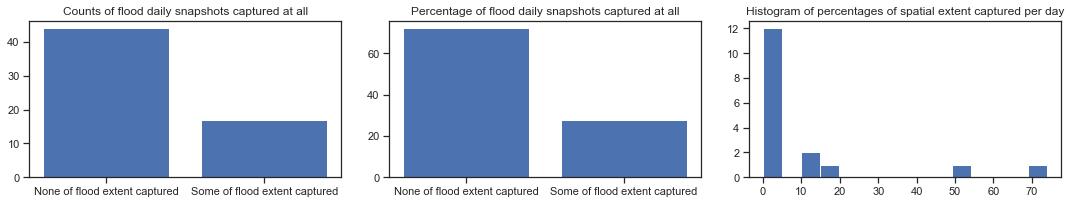

For floods that are captured at all, the percent of spatial extent captured for any given day ranges from  0.02 to 73.98


In [253]:
captured_any = master_df.groupby('captured_any').size()
captured_any.index = ["None of flood extent captured","Some of flood extent captured"]
fig, axs = plt.subplots(1, 3, figsize=[15,3], tight_layout=True)

axs[0].bar(captured_any.index,captured_any.values)
axs[0].set_title("Counts of flood daily snapshots captured at all")

axs[1].bar(captured_any.index,100*captured_any.values/sum(captured_any.values))
axs[1].set_title("Percentage of flood daily snapshots captured at all")

axs[2].hist(100*master_df[master_df.capture_percent>0].capture_percent, bins=15)
axs[2].set_title("Histogram of percentages of spatial extent captured per day")

plt.show()

print("For floods that are captured at all, the percent of spatial extent captured for any given day ranges from ",round(100*min(master_df[master_df.capture_percent>0].capture_percent),2),"to",round(max(100*master_df[master_df.capture_percent>0].capture_percent),2))

#### Take a quick look for any apparent correlation between the percent of spatial extent captured, and the basic characteristics of the flood snapshots

We can get a feel for any dependencied base don the rule of thumb applied to Pearson's r value:

* High Degree: Values between ±0.50 and ±1 suggest a strong correlation.
* Moderate Degree: Values between ±0.30 and ±0.49 indicate a moderate correlation

How does capture proportion relate to daily extent area in km?

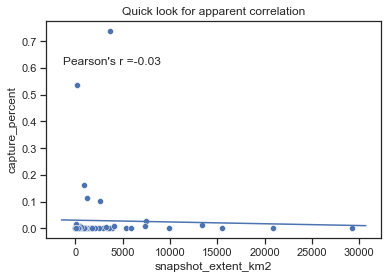

In [254]:
quickshow_corr(master_df.snapshot_extent_km2, master_df.capture_percent,'snapshot_extent_km2','capture_percent')

* Conclusion: capture percent is stable over a range of daily flood extents. This makes sense: the larger a flood, the more chance that **some** of it will be captured but the smaller percentage of the full extent that becomes.

* Insight: outliers of large capture percent (up to 70%) occur for ground-truth-extents in the range 0-5000 km2

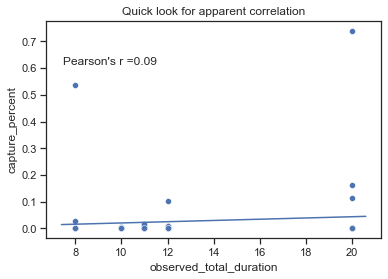

In [255]:
quickshow_corr(master_df.observed_total_duration, master_df.capture_percent,'observed_total_duration','capture_percent')

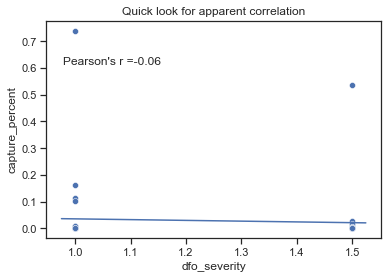

In [256]:
quickshow_corr(master_df.dfo_severity, master_df.capture_percent,'dfo_severity','capture_percent')

#### Conclusion: None of these basic flood snapshot characteristics exhibit even moderate correlation.

#### Next action: - Let's calculate some novel features of the daily flood extents.

In [257]:

def perimeter(binary_image):
    """
    The number of pixels around the boundaris of (one or more) discrete shapes in a binary image of flood extent
    """
    img = np.uint8(binary_image)
    contours, _ = cv2.findContours(img,  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return len(contours)

# perimeter of the flood extent, in number of pixels
master_df['extent_perimeter'] = master_df['snapshot_extent_img'].apply(lambda x : perimeter(x))
# complexity indicated by the ratio of the perimeter (in pixels) to the total area (in No of pixels)
master_df['shape_irregularity'] = master_df['extent_perimeter'] / (16 * master_df['snapshot_extent_km2']) # recall, one picel is a sixteenth of a km2


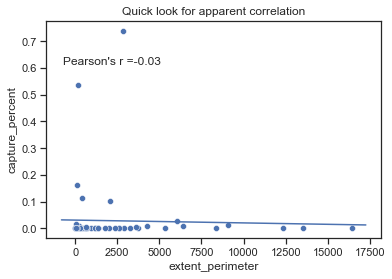

In [258]:
quickshow_corr(master_df.extent_perimeter, master_df.capture_percent,'extent_perimeter','capture_percent')

In [259]:
quickshow_corr(master_df.shape_irregulatity, master_df.capture_area_km,'shape_irregulatity','capture_area_km')

AttributeError: 'DataFrame' object has no attribute 'shape_irregulatity'

In [ ]:

def n_discrete_patches(binary_image):
    """
    The number of disconnected patches or 'islands' in a binary image.
    """
    _,island_count = measure.label(binary_image,background=0,return_num=True,connectivity=1)
    return island_count

# number of discrete / disconnected water bodies for the flood extent
master_df['n_water_bodies'] = master_df['snapshot_extent_img'].apply(lambda x : n_discrete_patches(x))

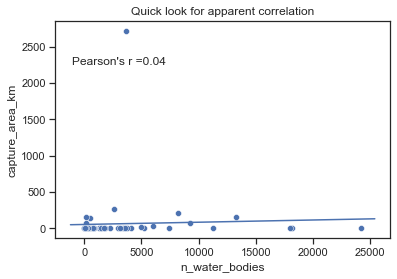

In [ ]:
quickshow_corr(master_df.n_water_bodies, master_df.capture_area_km,'n_water_bodies','capture_area_km')

In [ ]:
def shape_euler(binary_image):
    """
    For 2D objects, the Euler number is the number of objects minus the number of holes.
    """
    return measure.euler_number(binary_image)

# euler number of binary image of flood extent
master_df['euler_number'] = master_df['snapshot_extent_img'].apply(lambda x : shape_euler(x))

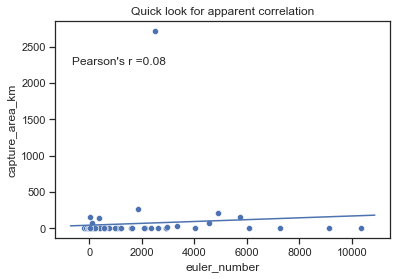

In [ ]:
quickshow_corr(master_df.euler_number, master_df.capture_area_km,'euler_number','capture_area_km')

#### Conclusion: None of these novel flood snapshot features on their own exhibit even moderate correlation.

#### Next action: - Let's see if a high dimensional model reveals any prdictive power.



Prepare the for data for model training (one-hot encoding and minmax re-scaling of numerical variables)

i) one-hot encoding

In [ ]:
# Perform one-hot encoding to replace "cause" column with binary columns per categorical cause value
master_df = pd.get_dummies(master_df, 
                              columns = ['cause'], 
                              dtype=int, #  values 0 & 1 
                              drop_first=False)


In [ ]:

predictor_columns=['flood_day',
                   'reported_duration', 
                   'observed_total_duration', 
                   'snapshot_extent_km2', 
                   #'cause_Heavy rain',          # these from 
                   # 'foo',                      # one-hot encoding
                   # 'bar'                       #
                   # 'baz                        # so far omitted because all values are the same (heavy rain the only cause)
                   'displaced_k',
                   'duration_days', 
                   'exposed_mn', 
                   'killed', 
                   'dfo_severity', 
                   'extent_perimeter', 
                   'shape_irregularity',
                   'n_water_bodies', 
                   'euler_number']

optional_target_columns=['capture_pixel_count', # these are the different things we could try to predict
                   'capture_percent',
                   'capture_area_km',
                   'captured_any'        # <-- this one suitable for binary classifier. Indicates whether any of the flood pixels at all were captured by Sentinel
                   ]



(ii) scaling to standard range (zero mean, unit variance)

In [ ]:

# rescale numerical values to range 0..1
temp_df = master_df[predictor_columns]
scaled_features = MinMaxScaler().fit_transform(temp_df.values)
scaled_df = pd.DataFrame(scaled_features, index=temp_df.index, columns=temp_df.columns)

for col in predictor_columns:
    master_df[col] = scaled_df[col]

master_df.head()


,DFO_id,flood_day,tif_filename,flood_year,flood_start,reported_duration,observed_total_duration,snapshot_date,snapshot_extent_img,snapshot_extent_km2,...,sentinel_coverage_Nboxes,capture_pixel_count,capture_percent,capture_area_km,captured_any,extent_perimeter,shape_irregulatity,n_water_bodies,euler_number,cause_Heavy rain
DFO_day_id,,,,,,,,,,,,,,,,,,,,,
DFO_4632_0,DFO_4632,0.000000,DFO_4632_From_20180615_to_20180620.tif,2018,2018-06-15,0.0,0.0,2018-06-15,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.256901,...,5,3389,0.028192,211.8125,1,0.368114,0.047570,0.337604,0.483972,1
DFO_4632_1,DFO_4632,0.052632,DFO_4632_From_20180615_to_20180620.tif,2018,2018-06-15,0.0,0.0,2018-06-16,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.183350,...,0,0,0.000000,0.0000,0,0.227958,0.040890,0.214531,0.295429,1
DFO_4632_2,DFO_4632,0.105263,DFO_4632_From_20180615_to_20180620.tif,2018,2018-06-15,0.0,0.0,2018-06-17,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.099322,...,5,63,0.001356,3.9375,1,0.123373,0.040859,0.121255,0.170144,1
DFO_4632_3,DFO_4632,0.157895,DFO_4632_From_20180615_to_20180620.tif,2018,2018-06-15,0.0,0.0,2018-06-18,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.039414,...,0,0,0.000000,0.0000,0,0.055941,0.047135,0.053395,0.089530,1
DFO_4632_4,DFO_4632,0.210526,DFO_4632_From_20180615_to_20180620.tif,2018,2018-06-15,0.0,0.0,2018-06-19,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.022305,...,5,0,0.000000,0.0000,0,0.029916,0.044424,0.029260,0.054818,1


Inspect the distributions and apparent inter-dependencies of each numerical feature

Data are split for visualization: blue = flood extent not captured by Sentinel-1, orange = that captured

Data are split for visualization: blue = flood extent not captured by Sentinel-1, orange = that captured


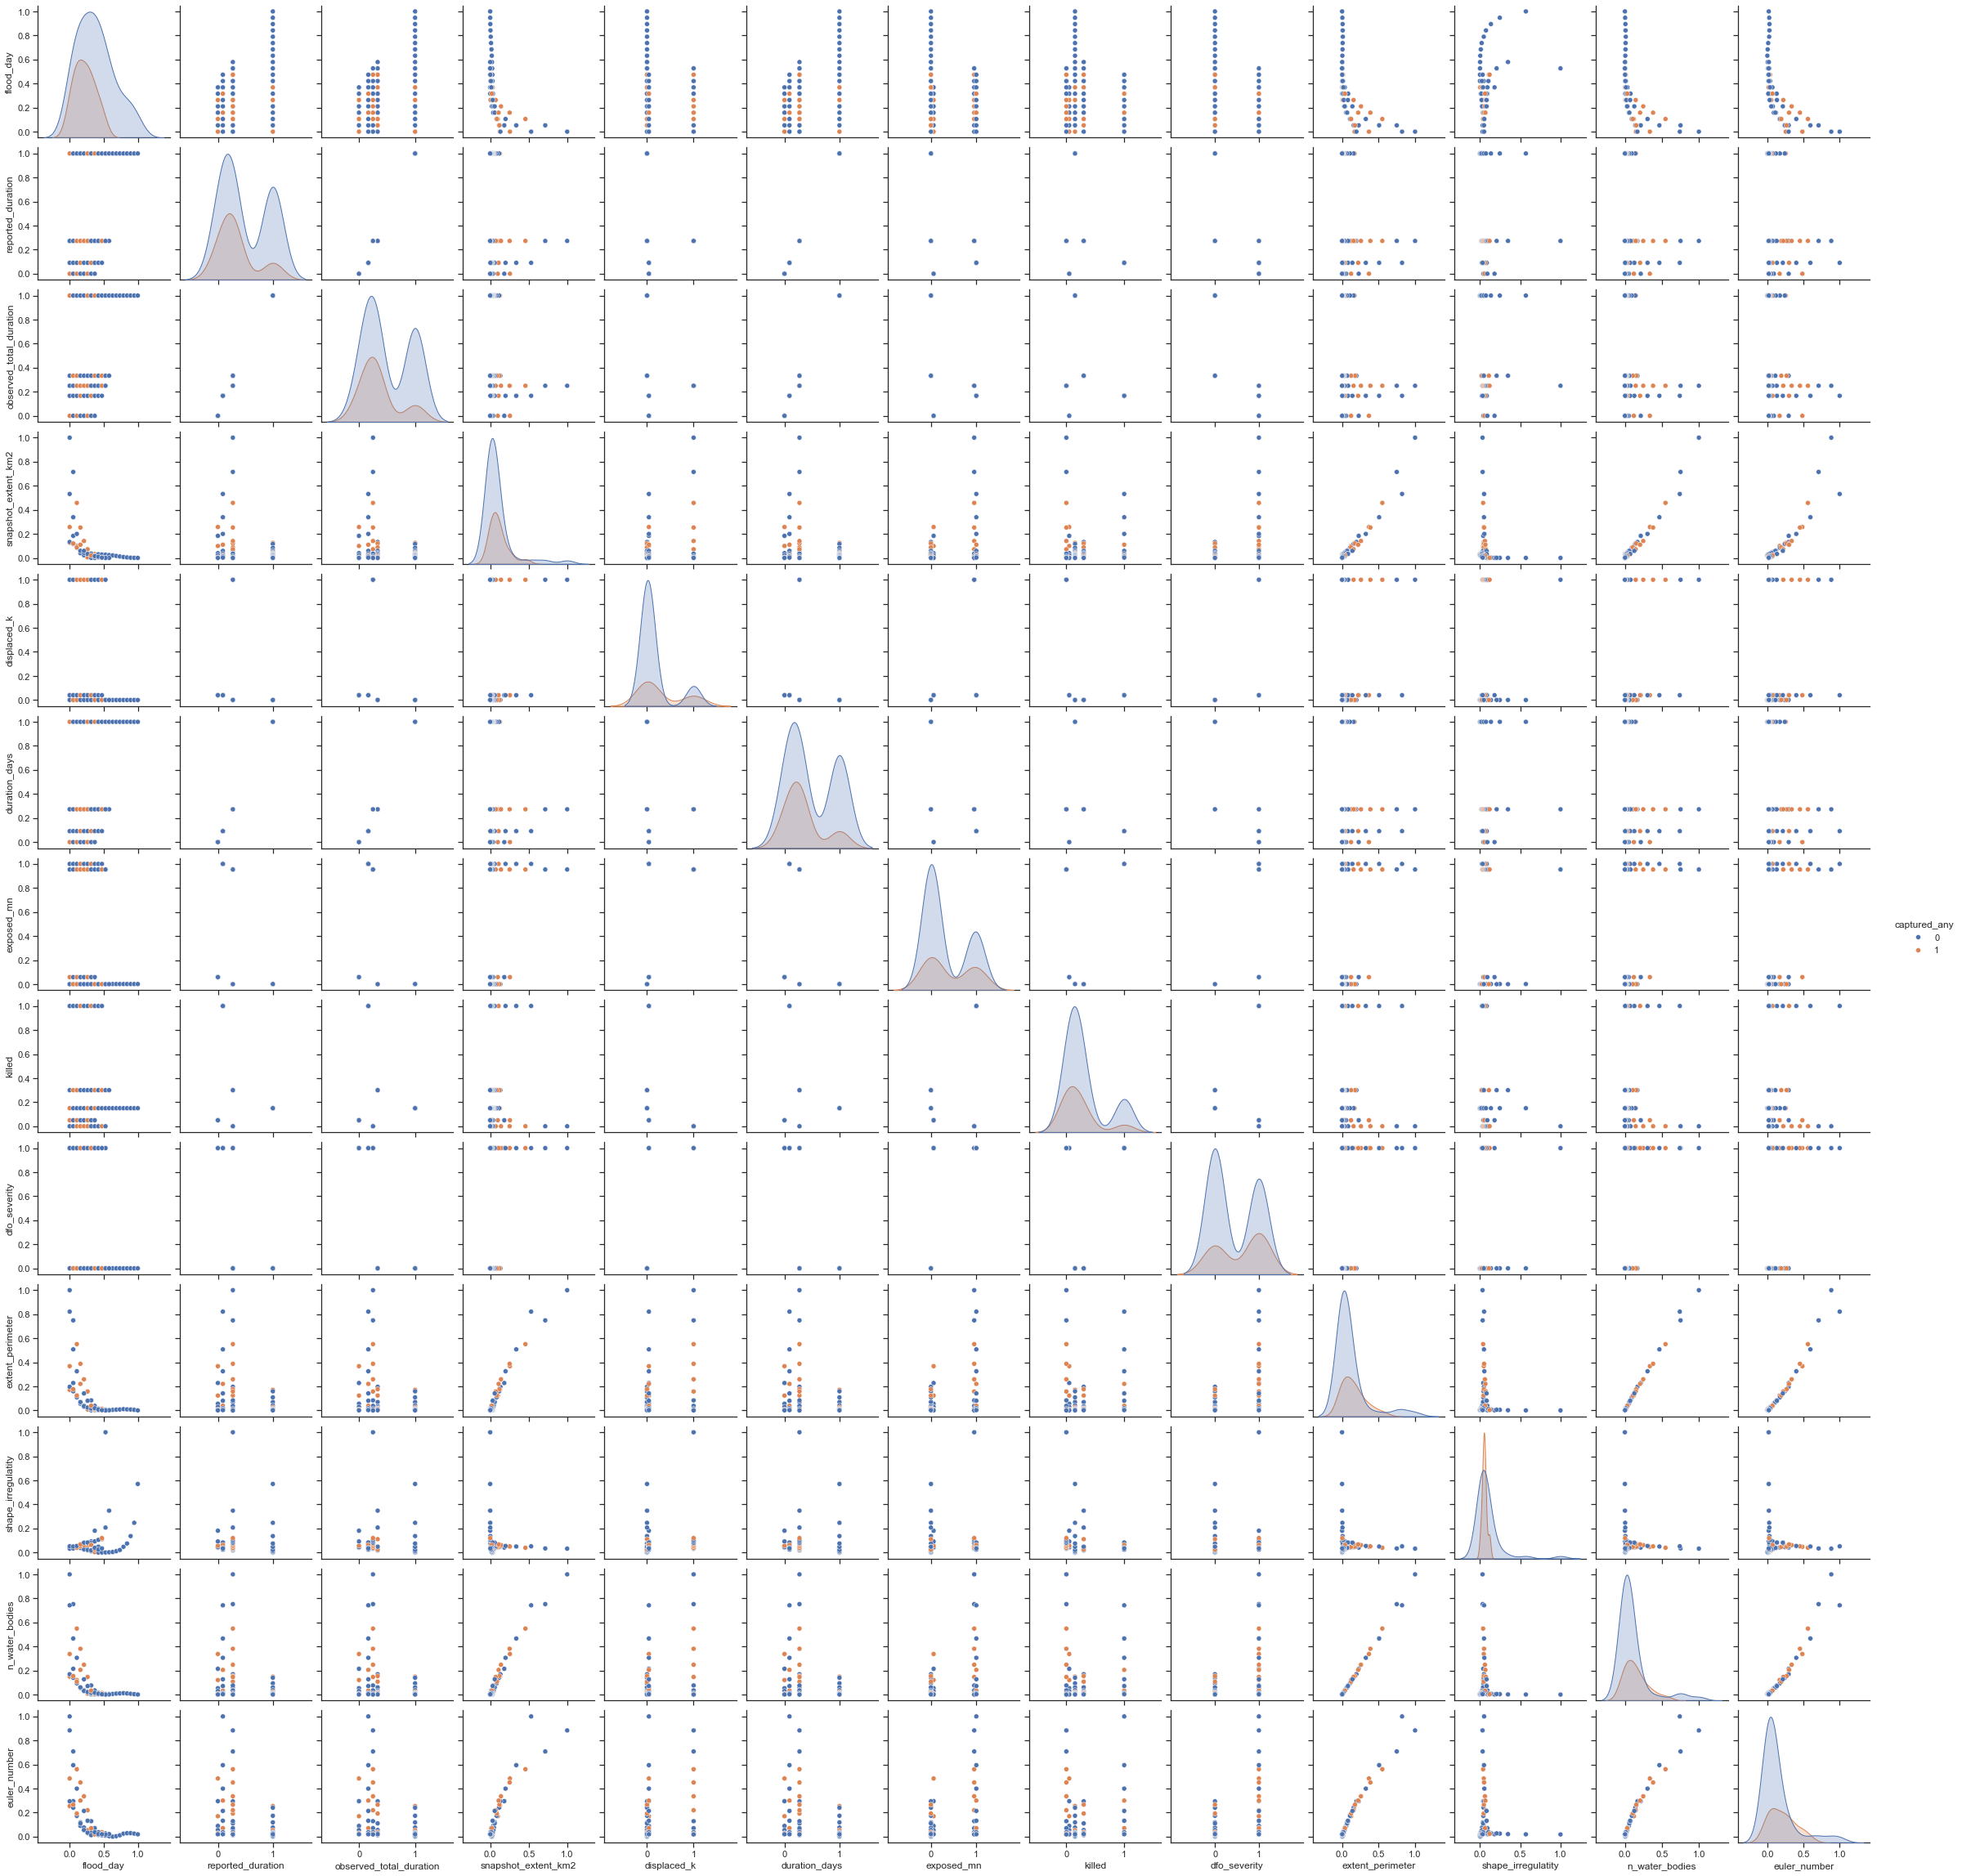

In [ ]:
print("Data are split for visualization: blue = flood extent not captured by Sentinel-1, orange = that captured")
sns.pairplot(master_df[predictor_columns+['captured_any']], hue='captured_any')

### Modeling 1: regressor to predict the proportion of a flood covered by Sentinel

In [ ]:
training_df= master_df[predictor_columns].copy()

r2 =  -9.820755641873848
root mean squared error =  0.03765694140954668
mean absolute error =  0.0357503648725858


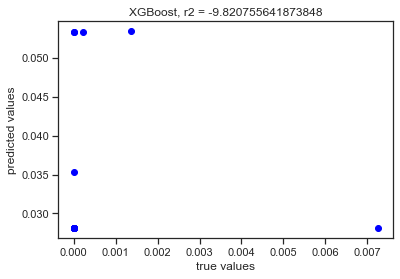

In [ ]:
target = master_df[optional_target_columns[1]] # capture_percent
X_train, X_test, y_train, y_test = train_test_split(training_df, target, random_state=14, test_size=0.2, stratify=target)

model = XGBRegressor(objective="reg:logistic")
model.fit(X_train, y_train)
predictions = model.predict(X_test)

r2 = r2_score(predictions, y_test)
rmse = math.sqrt(mean_squared_error(predictions, y_test))
mae = mean_absolute_error(predictions, y_test)

print("r2 = ",r2)
print("root mean squared error = ",rmse)
print("mean absolute error = ",mae)

quickshow_regression_results(y_test, predictions, "XGBoost",r2)

#### Conclusion: Higher-dimensional model using boosted decision forest for regression, does not reveal any predictive power of the flood characteristics

### Modeling 2: Binary classification to predict the label "captured or not" - defined by ANY GFD (true) flood extent pixel falling inside a Sentinel-1 ground coverage box on that day

In [ ]:
training_df= master_df[predictor_columns].copy()
target = master_df[optional_target_columns[3]] # 'captured_any' , which is the binary label for whether any flood coverage was captured
X_train, X_test, y_train, y_test = train_test_split(training_df, target, test_size=0.6, random_state=14, stratify=target)

Oversample the minority class (captured_any=1) to get more, and more balanced, training data

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 6
Before OverSampling, counts of label '0': 18 

After OverSampling, counts of label '1': 18
After OverSampling, counts of label '0': 18


First for XGBoost classifier 

In [ ]:
model = XGBClassifier()

model.fit(X_train_res, y_train_res) 
y_pred_xgb = model.predict(X_test)
y_pred_proba_xgb = model.predict_proba(X_test)[:, 1]

predictions_minireport(y_test,y_pred_xgb,"XGboost")

XGboost
true
0    26
1    11
dtype: int64
pred
0    28
1     9
dtype: int64


Repeat for Catboost classifier, which sometimes performs better

In [ ]:
model = CatBoostClassifier(iterations= 100, verbose = False)
pd.DataFrame.iteritems = pd.DataFrame.items # <-- bug fix for compatibility with pandas >2.0
model.fit(X_train_res, y_train_res) 
y_pred_cat = model.predict(X_test)
y_pred_proba_cat = model.predict_proba(X_test)[:, 1]

predictions_minireport(y_test,y_pred_cat,"Catboost")

Catboost
true
0    26
1    11
dtype: int64
pred
0    26
1    11
dtype: int64


Summarise the performance of both classifiers

range of 'capture at all' probabilities from xgboost 0.041199304  -  0.95187956
range of 'capture at all' probabilities from catboost 0.27639170877843144  -  0.7365243932040232


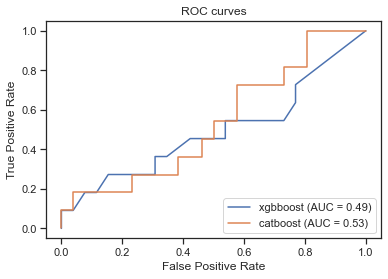

In [ ]:
print("range of 'capture at all' probabilities from xgboost",np.min(y_pred_proba_xgb)," - ",np.max(y_pred_proba_xgb))
print("range of 'capture at all' probabilities from catboost",np.min(y_pred_proba_cat)," - ",np.max(y_pred_proba_cat))

fpr_xgb,tpr_xgb,thresholds = roc_curve(y_test,y_pred_proba_xgb)
fpr_cat,tpr_cat,thresholds = roc_curve(y_test,y_pred_proba_cat)

fptps = {
    "xgbboost": [fpr_xgb,tpr_xgb],
    "catboost": [fpr_cat,tpr_cat]
}

aucs = {
    "xgbboost": roc_auc_score(y_test,y_pred_proba_xgb),
    "catboost": roc_auc_score(y_test,y_pred_proba_cat)
}

_, ax = plt.subplots()

model_displays = {}
for name in aucs:
    RocCurveDisplay(fpr=fptps[name][0], tpr=fptps[name][1], roc_auc=aucs[name]).plot(ax=ax, name=name)
_ = ax.set_title("ROC curves")


#### Conclusion: Higher-dimensional model using boosted decision forest for classification of whether a flood snapshot is captured at all (any of its extent), does not reveal any predictive power of the flood characteristics